In [1]:
# This notebook analyse candidate genes
# Author: Yiyun
import pandas as pd
import os, pickle
from scipy.stats import mannwhitneyu
from multiprocessing import Pool
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.pyplot import figure
import seaborn as sns
from matplotlib import gridspec
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'lines.linewidth':3,
         'font.sans-serif':'Ariel',
          'font.size':10}
# font = {'fontname':'monospace', 'size':'15'}
pylab.rcParams.update(params)

In [3]:
### Directories
# Read expression data
exp_dir = '../anno_ref/ICGC/pcawg_rnaseq/'
gene_tophatuq = 'tophat_star_fpkm_uq.v2_aliquot_gl.tsv'
gene_tophat = 'tophat_star_fpkm.v2.aliquot_gl.tsv'

### Read expression data 
# Read aliquot id information
df_exp_info = pd.read_csv(os.path.join(exp_dir,'rnaseq.metadata.tsv'), sep = '\t')
# Read expression information
# df_exp_uq = pd.read_csv(join(exp_dir,gene_tophatuq),sep = '\t', index_col = 0)
df_exp = pd.read_csv(os.path.join(exp_dir,gene_tophat),sep = '\t', index_col = 0)

In [4]:
# MAF file directory
dir_maf = '../maf_out/maf_cohorts_060121'
feature_type = 'histology'

# The significant gene lists
### Read synonymous candidate list and create pivot table for genes
cohorts = ['histology','organ','origin','system','pancancer']
dir_out = './figure4/'

# Read the significant gene dataframe after FDR calculation
feature_type = 'histology';syn_nsyn = 'syn';run = 'cohort_072221';threshold = 1;
df_syn = pd.read_csv(os.path.join(dir_out,feature_type+'.syn.df_all_forheatmap.'+run+'.'+str(threshold)+'.csv'),index_col = 0)
df_syn = df_syn.set_index('gene')

# Read the significant gene-id dataframe
fsig_name = 'sig_gene_name_id.csv'
df_nsig = pd.read_csv(os.path.join(dir_out, fsig_name))
df_nsig.columns = ['name', 'id']

In [13]:
def get_gene_exp(gene_name, df_expression):
    global df_nsig
    idx = df_nsig[df_nsig['name'] == gene_name].index
    gene_id = df_nsig.loc[idx, 'id'].values[0]
    df = df_expression.loc[df_expression.index.str.contains(rf'{gene_id}'),:]
    return df

def get_syn_mut(gene_name):
    global df_syn
    histology = df_syn.loc[gene_name,'feature']
    df_maf = pd.read_csv(os.path.join(dir_maf,feature_type, histology+'.csv'), sep = '\t')
    df_maf = df_maf.set_index(['Hugo_Symbol','Variant_Classification','Donor_ID' ])
    df_silent = df_maf.loc[pd.IndexSlice[gene_name, 'Silent',:],:]
    patient = df_silent.index.get_level_values('Donor_ID').unique().tolist()
    
    return df_silent, patient

def get_patient_id(gene_name, patients):
    global df_exp_info, df_syn
    histology = df_syn.loc[gene_name,'feature']
    df = df_exp_info[df_exp_info['histology_abbreviation'] == histology]
    
    # Get tumor, syn and normal patient aliquot id
    normal_id = df[df['tumor.normal'] == 'normal']['aliquot_id']
    df_tumor = df[df['tumor.normal'] == 'tumor']
    tumor_syn_id = df_tumor[df_tumor['icgc_donor_id'].isin(patients)]['aliquot_id']
    tumor_other_id = df_tumor[~df_tumor['icgc_donor_id'].isin(patients)]['aliquot_id']
    
    return normal_id, tumor_syn_id, tumor_other_id

def get_patient_exp(ids, df_gene_exp, tissue_type = None):
    df_for_test = df_gene_exp[ids].transpose()
    df = df_gene_exp[ids].transpose().reset_index()
    df['tumor.normal'] = tissue_type
    df.columns = ['id','exp','tumor.normal']
    
    return df, df_for_test

In [9]:
df_syn

,X,p,q,feature,exp.nonexp,FDR
gene,,,,,,
BCL2,0,0.000000,0.000000,Lymph-BNHL,exp,1.518254e-18
ITLN1,54504,0.000000,0.000000,CNS-PiloAstro,exp,1.518254e-18
XIRP2,109020,0.000000,0.000000,Skin-Melanoma,exp,1.518254e-18
SOX18,272521,0.000000,0.000000,Eso-AdenoCA,exp,1.518254e-18
SIGLEC15,345195,0.000000,0.000000,Panc-AdenoCA,exp,1.518254e-18
TP53I3,345196,0.000000,0.000000,Panc-AdenoCA,exp,1.518254e-18
CALR,399696,0.000000,0.000000,Uterus-AdenoCA,exp,1.518254e-18
PPWD1,417864,0.000000,0.000000,Head-SCC,exp,1.518254e-18
PURA,563208,0.000000,0.000000,Breast-AdenoCA,exp,1.518254e-18


In [47]:
gene = 'TPM2'
histology = df_syn.loc[gene,'feature']

df_exp_gene = get_gene_exp(gene, df_exp)
df_synmut, synp = get_syn_mut(gene)
id_normal, id_syn, id_other =get_patient_id(gene, synp)

df_normal, normal_test = get_patient_exp(id_normal, df_exp_gene, 'normal')
df_tsyn, syn_test = get_patient_exp(id_syn, df_exp_gene,'tumor_syn')
# if len(df_tsyn) == 0:
#     break
df_tother, other_test = get_patient_exp(id_other, df_exp_gene, 'tumor_other')
df_all = pd.concat([df_normal,df_tsyn,df_tother])

nnorm = len(df_normal['id'].unique())
print(nnorm)
nsyn = len(df_tsyn['id'].unique())
print(nsyn)
nother = len(df_tother['id'].unique())
print(nother)


fig,ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(x = 'tumor.normal', y = 'exp', data = df_all)

mannwhitneyu(syn_test, other_test)
text = f'test statistic:{round(mannwhitneyu(syn_test, other_test)[0],4)},p-value:{round(mannwhitneyu(syn_test, other_test)[1],4)}'
ax.text(1, 0.9, text, fontsize=12, va='top')
ax.set_title(histology+'_'+gene+'_'+text)
# plt.savefig('./res/'+organ_type+'_'+gene_name+'.png')

if (mannwhitneyu(syn_test, other_test)[1] < 0.05) and (mannwhitneyu(syn_test, other_test)[0]>0):
    print(gene)
plt.show()

/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-bzb/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


0
0
0


ValueError: min() arg is an empty sequence

/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1,17,33,34,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


['DO20082', 'DO19733', 'DO48495']
['Silent']
['Silent']
['Silent']
['DO20082', 'DO19733', 'DO48495']
                                     id         exp tumor.normal
0  7694eaf3-732e-4b23-b8fe-ce713c1a4b18   18.298739    tumor_syn
1  29739602-d94f-4341-849e-a5b8a4c342eb  110.871777    tumor_syn
2  536d11ba-aa02-4443-96e8-6e9e9898ceb7   21.832894    tumor_syn


/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/matplotlib/patches.py:3049: RuntimeWarning: invalid value encountered in double_scalars
  ddx, ddy = dx / dd, dy / dd
/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/matplotlib/patches.py:3049: RuntimeWarning: invalid value encountered in double_scalars
  ddx, ddy = dx / dd, dy / dd


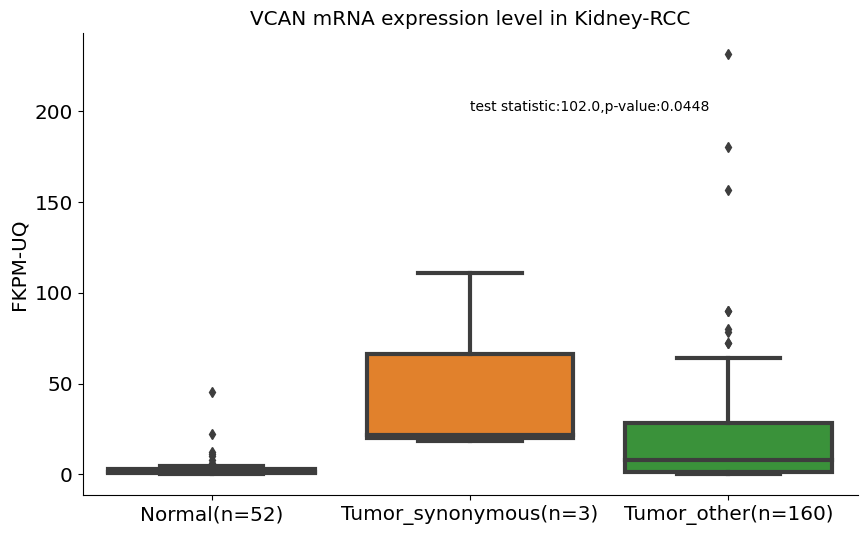

In [16]:
### Parameter card
### Parameter card
gene_name = 'VCAN'
gene_id = sig_genes_syn.loc[sig_genes_syn[sig_genes_syn['gene_name'] == gene_name].index,'gene_id'].tolist()[0]

organ_type = 'Kidney'
organ_subtype = None
df_exp_gene = get_gene_exp(gene_id, df_exp_uq)
syn_patients, syn_mut_df = get_cancer_patients(organ_type, gene_name, subtype = organ_subtype)
id_normal, id_syn, id_other = get_patient_id(organ_type, syn_patients, subtype = organ_subtype)


# Get expression and combine tumor, syn and normal df
df_normal, normal_test = get_patient_exp(id_normal, df_exp_gene, 'normal')
df_syn, syn_test = get_patient_exp(id_syn, df_exp_gene,'tumor_syn')
df_other, other_test = get_patient_exp(id_other, df_exp_gene, 'tumor_other')
df_all = pd.concat([df_normal,df_syn,df_other])
print(df_syn)

fig,ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(x = 'tumor.normal', y = 'exp', data = df_all)
ax.set_title(organ_type+'_'+gene_name)
mannwhitneyu(syn_test, other_test)
text = f'test statistic:{round(mannwhitneyu(syn_test, other_test)[0],4)},p-value:{round(mannwhitneyu(syn_test, other_test)[1],4)}'
ax.set_xticklabels([f'Normal(n={len(normal_test)})', f'Tumor_synonymous(n={len(syn_test)})', f'Tumor_other(n={len(other_test)})'])
ax.set_xlabel('')
ax.set_ylabel('FKPM-UQ')
ax.set_title(gene_name+' mRNA expression level in Kidney-RCC')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
ax.annotate(text, xy=(1,200), zorder=10)
ax.annotate('', xy=(1,2), xytext=(1,2), arrowprops=props)
plt.savefig(os.path.join('figure6', 'VCAN.pdf'))